In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Outline

Via is considering expanding its service area to include Astoria, Queens. We are trying to find the optimal way to launch this expansion.

We are using the NYC taxi data from the period before July 2016 (described and available here: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml, also available either through BiqQuery https://bigquery.cloud.google.com/table/imjasonh-storage:nyctaxi.trip_data, or in smaller samples from http://www.andresmh.com/nyctaxitrips/), to answer the following questions:

Analysis Questions:

1. How would we assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?

2. How does this compare to our current area of service (e.g. the Upper East Side)?

3. Would we provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why?

4. Would we launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?

Statistical Questions:

5. If given a metric for efficiency (assume we don't know how it's calculated), how to determine whether a specific zone is more efficient than the rest of the city? How would we determine why it’s more efficient?

6. How would we compare the distributions of intra-city trip prices between two different cities? How would we test whether any differences we find are explained by distance and duration?

The report will be organized in this way:

  1. [Exploring the Data](#chapter-1)
      1. [Data Inspection and Preprocessing](#chapter-1a)
      2. [Exploratory Data Visualization](#chapter-1b)
      
  2. [Expansion to Astoria](#chapter-2)
      1. [How is the efficiency in this area? How does it compare to current areas of service?](#chapter-2a)
      2. [Shall we provide rides only within Astoria or also between Astoria and Manhattan?](#chapter-2b)
      3. [Which hours shall we launch Astoria services?](#chapter-2c)
      
  3. [Further Insights](#chapter-3)
      1. [Improve efficiency by recommending next ride for driver](#chapter-3a)
      
  4. [Statistical Questions](#chapter-4)
      1. [How to determine whether a zone is more efficient? How to determine why it's more efficient?](#chapter-4a)
      2. [How to compare distributions of trip prices between different cities? How to test whether differences are explained by distance and duration?](#chapter-4b)
      
  5. [Conclusions and Insights](#chapter-5)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle

from sqlalchemy import create_engine
from sqlalchemy.sql import text
import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

DEBUG = False

## 1. Exploring the Data <a id="chapter-1"></a>

### A) Data Inspection and Preprocessing<a id="chapter-1a"></a>
The data used in this report were collected by the New York City Taxi and Limousine Commission (NYC TLC) on the trip by trip basis and downloaded from http://www.andresmh.com/nyctaxitrips/. This data set recorded all the taxi trips in New York City from January, 2013 to December, 2013. To understand the stable taxi ride pattern, I will be focusing on the data recored in August, 2013 for one month, which contains more than 12,000,000 rides. 

The data is stored in two seperate tables with the following schema:

** Table 1: trip_data**

|columns| description |
|--------------|---|
| medallion    | Medallion license id for taxi.  |
| hack_license | The taxi driver license id. |
| vendor_id    | A code indicating the TPEP provider that provided the record.   |
| rate_code    | The final rate code in effect at the end of the trip.\* |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor. |
| pickup_datetime    | The date and time when the meter was engaged.   |
| dropoff_datetime    | The date and time when the meter was disengaged.   |
| passenger_count    | The number of passengers in the vehicle. Driver entered value. |
| trip_time_in_secs    | The trip time in seconds. |
| trip_distance   |  The elapsed trip distance in miles reported by the taximeter  |
| pickup_longitude    | Longitude where the meter was engaged.  |
| pickup_latitude    | Latitude where the meter was engaged.  |
| dropoff_longitude     | Longitude where the meter was disengaged.  |
| dropoff_latitude    |  Lattitude where the meter was disengaged. |

\* rate code:

1 = Standard rate; 2 = JFK; 3 = Newark; 4 = Nassau or Westchester; 5 = Negotiated fare; 6 = Group ride

**Table 2: trip_fare**

|columns| description |
|--------------|---|
| medallion    | Medallion license id for the taxi.  |
| hack_license | The taxi driver license id.  |
| vendor_id    | A code indicating the TPEP provider that provided the record.  |
| pickup_datetime    | The date and time when the meter was engaged.  |
| payment_type  | A numeric code signifying how the passenger paid for the trip.\*  |
| fare_amount  | The time-and-distance fare calculated by the meter  |
| surcharge  |  Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
|  mta_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use.  |
|  tip_amount    | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.  |
|  tolls_amount    | Total amount of all tolls paid in trip.   |
|  total_amount    | The total amount charged to passengers. Does not include cash tips.  |

\* payment type code:

1 = Credit card; 2 = Cash; 3 = No charge; 4 = Dispute; 5 = Unknown; 6 = Voided trip

#### Handling Missing and wrong values in the dataset

During the inspection of the two tables, I found there are several thousands of rows with missing values or wrong values. I decided to drop all these rows since the number of rows are very small compared to the total amount of data. 

1. Passenger count:
There are rides with 0 or 208 passengers which should be wrong values entered accidentally by drivers.
2. Trip time: Trip time can not be negative or longer than one day (86400 seconds).
3. Trip distance: Distance longer than 100 miles are unreasonably high for taxi rides in NYC.
4. fare: The payment amount for all kinds of fees and fare should not be nagative.

After the data cleaning process, there are 12,303,170 rides in the dataset during August, 2013.

#### Finding the corresponding zone for pickup and dropoff coordinates

For future analysis, we need to find out the taxi zone and corresponding boroughs for each pickup and dropoff location. A shapefile containing the boundaries for the taxi zones and the TLC taxi zone location IDs, location names and corresponding boroughs for each ID can be found  on http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml. 

With the given shapefile, I wrote a script (./data_clean_preprocessing.py) to find out the pickup and dropoff location ID for all the rides in the dataset, and save them as two new columns "pickup_LocationID" and "dropoff_LocationID".

In [5]:
zones = pd.read_csv("./taxi_zones/taxi_zone_lookup.csv")

#The taxi zones that each borough contains
Manhattan_zones = zones[zones.Borough=="Manhattan"]["LocationID"].tolist()
Queens_zones = zones[zones.Borough=="Queens"]["LocationID"].tolist()
Bronx_zones = zones[zones.Borough=="Bronx"]["LocationID"].tolist()
Brooklyn_zones = zones[zones.Borough=="Brooklyn"]["LocationID"].tolist()
Staten_Island_zones = zones[zones.Borough=="Staten Island"]["LocationID"].tolist()
EWR_zones = zones[zones.Borough=="EWR"]["LocationID"].tolist()

#The regions that we are particularly interested in: Astoria, Laguardia, and Upper East Side
Astoria_zones = zones[[row in ["Astoria", "Old Astoria", "Astoria Park"] 
                       for row in zones.Zone]]["LocationID"].tolist()
Laguardia_zones = zones[zones.Zone == "LaGuardia Airport"]["LocationID"].tolist()

Upper_east_zones = zones[[row in ["Upper East Side North", "Upper East Side South"] 
                          for row in zones.Zone]]["LocationID"].tolist()

#Steinway_zones = zones[zones.Zone == "Steinway"]["LocationID"].tolist()
#Jackson_zones = zones[zones.Zone == "Jackson Heights"]["LocationID"].tolist()
#Woodside_zones = zones[zones.Zone == "Woodside"]["LocationID"].tolist()

In [6]:
def region(location_id):
    if location_id in Astoria_zones:
        return "AST"
    elif location_id in Laguardia_zones:
        return "LAG"
    elif location_id in Upper_east_zones:
        return "UES"
    #elif location_id in Steinway_zones:
    #    return "STW"
    #elif location_id in Jackson_zones:
    #    return "JKH"
    #elif location_id in Woodside_zones:
    #    return "WDS"
    else:
        return

In [7]:
def borough(location_id):
    if location_id in Manhattan_zones:
        return "MAN"
    elif location_id in EWR_zones:
        return "EWR"
    elif location_id in Queens_zones:
        return "QUE"
    elif location_id in Bronx_zones:
        return "BRX"
    elif location_id in Brooklyn_zones:
        return "BKL"
    elif location_id in Staten_Island_zones:
        return "STI"
    else:
        return

#### Merging trip_data and trip_fare and Loading data in Sqlite database
After preprocessing and dropping unnecessary columns, I merge the trip_data and trip_fare into a single table and load it into a sqlite db.

In [8]:
disk_engine = create_engine('sqlite:///trip_data_2013.db')

### B) Exploratory Data Visualization<a id="chapter-1b"></a>

![alt text](./heatmap/pickup.gif "Title")

![alt text](./heatmap/dropoff.gif "Title")

## 2. Expansion to Astoria <a id="chapter-2"></a>

### A) How is the efficiency within Astoria, between Astoria and Manhattan, from LaGuardia airport through Astoria to Manhattan and back? How does it compare to current areas of service? <a id="chapter-2a"></a>

The efficiency of rides within a certain region or along a certain route can be evaluated in several different aspects. From the taxi drivers' point of view, the most important metric is the amount of money earned per unit time; while for passengers, the distance travelled per unit time will be more important. As for the whole taxi system, using less drivers to provide services for more passengers to reach their destinations in shorter time is the ultimate goal. 

Therefore, I considered several different factors to access the efficiency of rides:

  - distance travelled per unit time 
  - fare earned by the driver per unit time 
  - average number of passengers per ride
  - the average waiting time for drivers to find the next passengers after their last ride 
    
In order to compare the efficieny between Astoria and the current area of service (in this report I choose Upper East Side as an example), I calcuated the efficiency metrics for both areas in parallel, including rides within the area of interest, between LaGuardia Airport and this area, and between all other zones in Manhattan and this area.

#### Distance traveled / fare earned per minute, number of passengers per ride

The following plots compare the average trip time/distance, distance/fare per minute, and number of passengers for Astoria services and the current Upper Ease Side services. From the aggregated analysis, we can see that:

  * The average fare earned per minute and average number of passengers are very similar between those two areas
  * The distance traveled per minute for rides between Astoria and Manhattan are much higher than Upper East Side, while the rides from Astoria to LaGuardia airport have relatively lower distance traveled per minute compared to Upper East Side.

In [ ]:
def query_regional_rides(region_zones):
    # aggregating the rides within the specified region, 
    #                       between this region and LaGuardia, 
    #                       between this region and Manhattan
    
    query_region = '''SELECT * 
                       FROM ( SELECT *, 
                           CASE WHEN pickup_LocationID IN ({region_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "within" 
                           WHEN pickup_LocationID IN ({region_ids}) 
                             AND dropoff_LocationID IN ({laguardia_ids}) THEN "from_lag" 
                           WHEN pickup_LocationID IN ({laguardia_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "to_lag" 
                           WHEN pickup_LocationID IN ({manhattan_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "from_man"
                           WHEN pickup_LocationID IN ({region_ids})
                             AND dropoff_LocationID IN ({manhattan_ids}) THEN "to_man" 
                           ELSE NULL 
                           END AS zones 
                           FROM trip_data )
                       WHERE zones IS NOT NULL '''
    f = {"region_ids": ",".join([str(i) for i in region_zones]), 
        "laguardia_ids": ",".join([str(i) for i in Laguardia_zones]), 
         "manhattan_ids": ",".join([str(i) for i in Manhattan_zones])}

    return pd.read_sql_query(query_region.format(**f), disk_engine)

df_Astoria = query_regional_rides(Astoria_zones)
print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
print "within Astoria:                    ", len(df_Astoria[df_Astoria.zones=="within"])
print "from Astoria to LaGuardia Airport: ", len(df_Astoria[df_Astoria.zones=="to_lag"])
print "from LaGuardia Airport to Astoria: ", len(df_Astoria[df_Astoria.zones=="from_lag"])
print "from Astoria to Manhattan:         ", len(df_Astoria[df_Astoria.zones=="to_man"])
print "from Manhattan to Astoria:         ", len(df_Astoria[df_Astoria.zones=="from_man"])

df_Upper = query_regional_rides(Upper_east_zones)
print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
print "within Upper East Side:                    ", len(df_Upper[df_Upper.zones=="within"])
print "from Upper East Side to LaGuardia Airport: ", len(df_Upper[df_Upper.zones=="to_lag"])
print "from LaGuardia Airport to Upper East Side: ", len(df_Upper[df_Upper.zones=="from_lag"])
print "from Upper East Side to Manhattan:         ", len(df_Upper[df_Upper.zones=="to_man"])
print "from Manhattan to Upper East Side:         ", len(df_Upper[df_Upper.zones=="from_man"])

df_Astoria["region"] = "AST"
df_Upper["region"] = "UES"
df_rides = pd.concat([df_Astoria, df_Upper], axis=0)

agg_rides = df_rides[['region', 'zones', 'passenger_count', 'trip_distance', 'trip_time', 'fare_amount']] \
                        .groupby(['zones', 'region']).mean().reset_index()

agg_rides["fare_per_minute"] = agg_rides["fare_amount"]/agg_rides["trip_time"]*60.0
agg_rides["dist_per_minute"] = agg_rides["trip_distance"]/agg_rides["trip_time"]*60.0

agg_rides

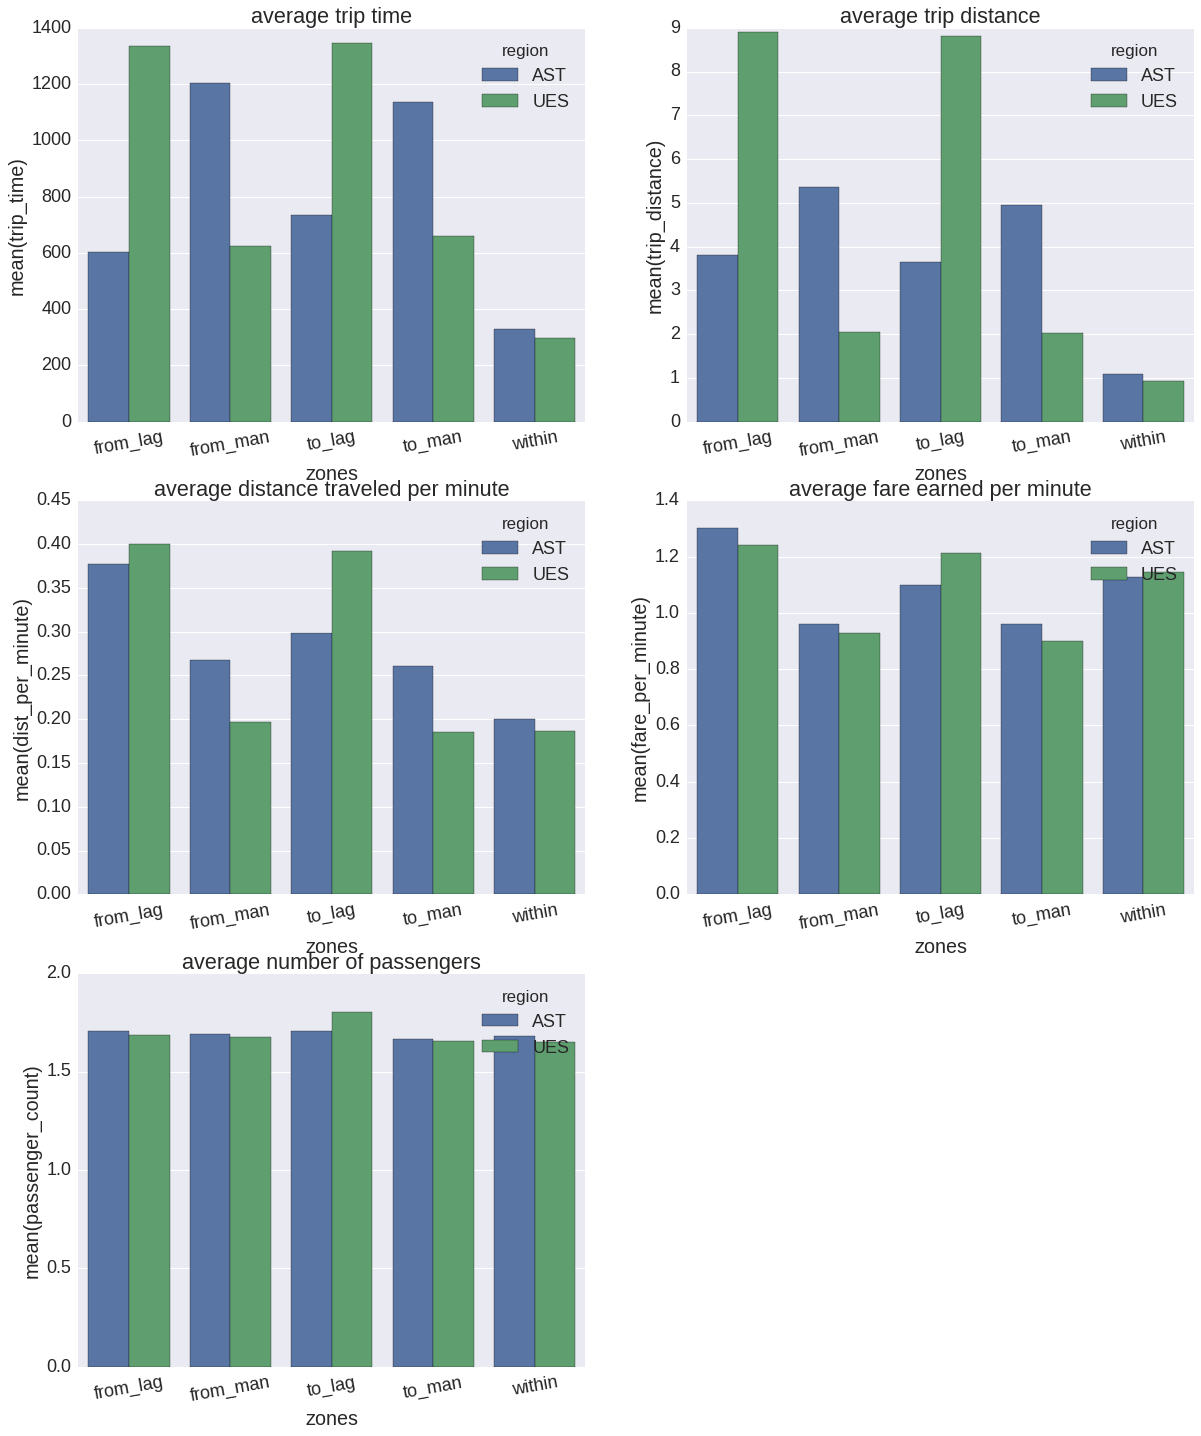

In [10]:
def plot_bar(df, x_cols, y_cols, titles):
    n_y = len(titles)/2 + 1
    plt.figure(figsize=(20,n_y*8))
    for i in range(len(titles)):
        plt.subplot(n_y, 2, i+1)
        sns.barplot(x=x_cols[i],y=y_cols[i],data=df, hue='region')
        plt.xticks(rotation=10)
        plt.title(titles[i])

y_cols = ["trip_time", "trip_distance", "dist_per_minute", "fare_per_minute", "passenger_count"]
x_cols = ["zones"]*len(y_cols)
titles = ["average trip time", "average trip distance", "average distance traveled per minute",
          "average fare earned per minute", "average number of passengers"]

sns.set(font_scale=1.8)
plot_bar(agg_rides, x_cols, y_cols, titles)

#### Waiting time for drivers to find their next passengers

The last metric efficiency I calculated is the average time for taxi drivers to find their next passengers after dropping the previous passengers off in a certain area. To be more specific, I wants to find out all the unique taxis (according to their medallion ids) that dropped off in Astoria, then find out the time difference between this ride's dropoff time and the next pickup time for the same taxi. I ignored the case when duration exceeds 6 hours since this might mean the driver has finished his/her shift for the day. In order to do this, I wrote script to perform parallel calculations to get results faster.

Let's take a look at the results for the average time (minutes) for drivers to find their next trip in Astoria, LaGuardia Airport, and Upper East Side during different hours in weekdays and weekends.

In [8]:
df_wait = pd.read_csv("./wait_time/august_wait_time.csv")
df_wait["region"] = df_wait["dropoff_LocationID"].apply(region)
agg_wait = df_wait[["wait_time", "region"]].groupby("region").describe() \
                                            .stack(level=1).reset_index()
agg_wait.columns = ['region', 'statistics', 'wait_time']

In [9]:
#sns.set(font_scale=1.5)
#sns.barplot(x='region',y='wait_time',
#            data=agg_wait[agg_wait.statistics.isin(["mean", "50%"])], 
#            hue='statistics')
#plt.title("waiting time when dropping off at different regions")

In [12]:
df_wait["hour"] = df_wait["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_wait["weekday"] = df_wait["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).weekday())
df_wait["weekday"] = df_wait["weekday"].apply(lambda x: "weekday" if x<5 else "weekend")
agg_wait_by_hour = df_wait[["wait_time", "region", "weekday", "hour"]] \
                    .groupby(["region", "weekday", "hour"]).median().reset_index()

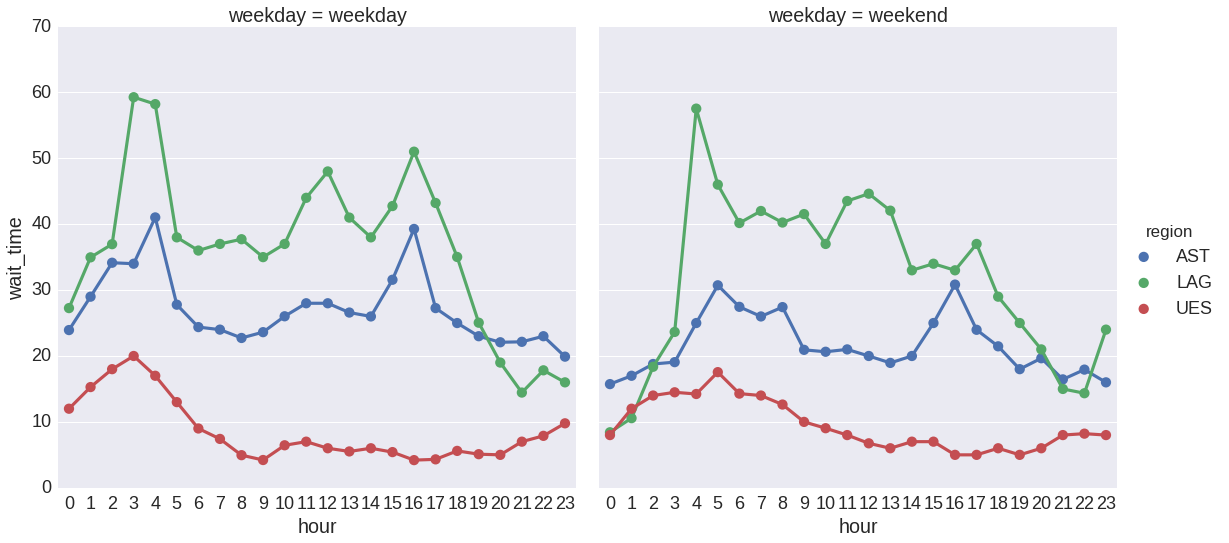

In [90]:
sns.set(font_scale=1.8)
g=sns.factorplot(x='hour',y='wait_time', col="weekday",
               data=agg_wait_by_hour,
               hue='region',  size=8)

In general, the waiting time in Astoria is much longer than Upper East Side, especially during certain hours of the day (1am-5am, 3pm-6pm). But on the other hand, compared to LaGuardia Airport, the waiting time in Astoria is much shorter. And since Astoria is rather close to LaGuardia(15min of driving), this indicates that opening the Astoria service could provide a chance for the drivers to drive from LaGuardia to Astoria to seek for their next clients.

### B) Shall we provide rides only within Astoria or also between Astoria and Manhattan? Why? <a id="chapter-2b"></a>


In [11]:
df_Astoria = query_regional_rides(Astoria_zones)
df_Astoria["region"] = "AST"
df_Upper_east = query_regional_rides(Upper_east_zones)
df_Upper_east["region"] = "UES"

count_rides= df_Astoria[["region", "zones", "index"]].groupby(["region", "zones"]).count().reset_index()

count_rides.columns = ["region", "zones", "number_of_rides"]
count_rides["number_of_rides"] = count_rides["number_of_rides"]/31.0/24.0

Average number of rides per hour within Astoria, between Astoria 
             and Manhattan, and between Astoria and LaGuardia


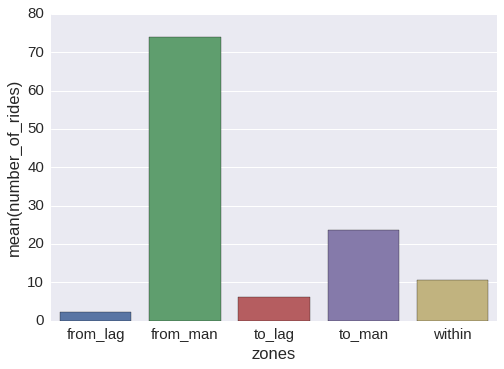

In [95]:
sns.set(font_scale=1.5)
sns.barplot(x='zones',y='number_of_rides',
            data=count_rides[count_rides.region=="AST"])
print("Average number of rides per hour within Astoria, between Astoria \n \
            and Manhattan, and between Astoria and LaGuardia")

### C) Which hours shall we launch Astoria services? <a id="chapter-2c"></a>
**Question 4. Would you launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?**

In [66]:
df_Astoria["hour"] = df_Astoria["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_Astoria["weekday"] = df_Astoria["pickup_datetime"].apply(lambda x: pd.to_datetime(x).weekday())

df_Astoria.weekday = df_Astoria.weekday.apply(lambda x: "weekday" if x<5 else "weekend")

hourly_count = df_Astoria[["zones", "index", "hour", "weekday"]].groupby(["hour", "zones", "weekday"]) \
                        .count().reset_index()
if DEBUG:
    hourly_count.head()

hourly_count.columns = ["hour", "zones", "weekday", "number_of_rides"]
# number of weekdays in 2013 august: 22
hourly_count.loc[hourly_count.weekday=="weekday","number_of_rides"] = \
                    hourly_count.loc[hourly_count.weekday=="weekday","number_of_rides"]/22.0
# number of weekends in 2013 sugust: 9
hourly_count.loc[hourly_count.weekday=="weekend","number_of_rides"] = \
                    hourly_count.loc[hourly_count.weekday=="weekend","number_of_rides"]/9.0

Average number of rides per hour within Astoria


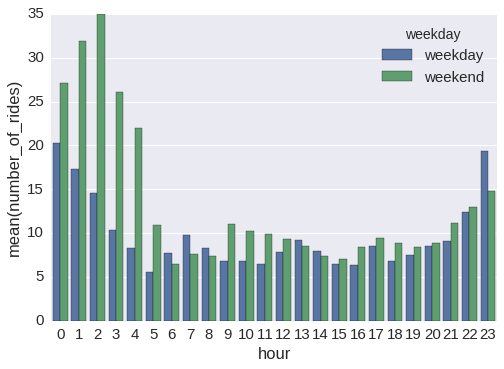

In [96]:
sns.set(font_scale=1.5)
g = sns.barplot(x='hour',y='number_of_rides',
            data=hourly_count[hourly_count.zones=="within"],
            hue="weekday")
print("Average number of rides per hour within Astoria")

Average number of rides per hour from Manhattan to Astoria


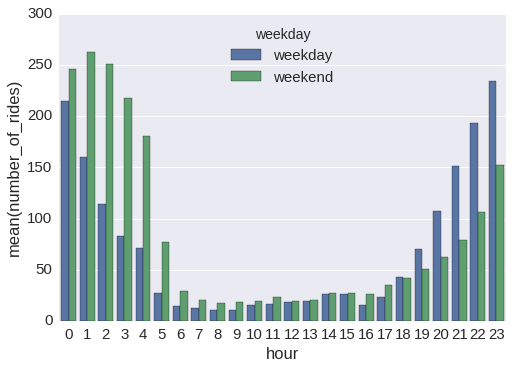

In [97]:
sns.set(font_scale=1.5)
g = sns.barplot(x='hour',y='number_of_rides',
            data=hourly_count[hourly_count.zones=="from_man"],
            hue="weekday")
print("Average number of rides per hour from Manhattan to Astoria")

Average number of rides per hour from Astoria to Manhattan


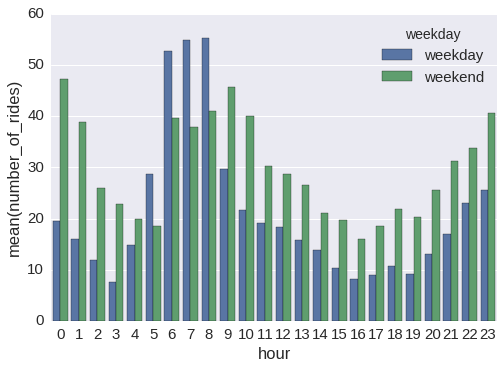

In [98]:
sns.set(font_scale=1.5)
g = sns.barplot(x='hour',y='number_of_rides',
            data=hourly_count[hourly_count.zones=="to_man"],
            hue="weekday")
print("Average number of rides per hour from Astoria to Manhattan")

## Further Insights

Improve efficiency by recommending next ride for driver

### flow of traffic during different hours of the day

In [19]:
def query_flow(zones, is_in):
    if is_in:
        # query all the rides coming in to the regions
        query_rides = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE dropoff_LocationID IN ({zone_ids})'''
    else:
        # query all the rides coming out of the regions
        query_rides = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE pickup_LocationID IN ({zone_ids})'''
    f = {"zone_ids": ",".join([str(i) for i in zones])}
    return pd.read_sql_query(query_rides.format(**f), disk_engine)

In [20]:
df_flow_in = query_flow(Astoria_zones+Laguardia_zones+Upper_east_zones, is_in=True)
if DEBUG:
    print "Number of rides: ", len(df_flow_in)
    df_flow_in.head()

df_flow_out = query_flow(Astoria_zones+Laguardia_zones+Upper_east_zones, is_in=False)
if DEBUG:
    print "Number of rides: ", len(df_flow_out)
    df_flow_out.head()

In [26]:
df_flow_in["hour"] = df_flow_in["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_flow_in["weekday"] = df_flow_in["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).weekday())
df_flow_in["weekday"] = df_flow_in["weekday"].apply(lambda x: "weekday" if x<5 else "weekend")
df_flow_in["region"] = df_flow_in["dropoff_LocationID"].apply(region)

agg_flow_in = df_flow_in[['region', 'weekday', 'hour', 'dropoff_datetime']] \
                .groupby(['region', 'weekday', 'hour'], as_index=False).count()
agg_flow_in.columns = ["region", "weekday", "hour", "count_incoming"]
if DEBUG:
    print agg_flow_in.head()

df_flow_out["hour"] = df_flow_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_flow_out["weekday"] = df_flow_out["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).weekday())
df_flow_out["weekday"] = df_flow_out["weekday"].apply(lambda x: "weekday" if x<5 else "weekend")
df_flow_out["region"] = df_flow_out["pickup_LocationID"].apply(region)

agg_flow_out = df_flow_out[['region', 'weekday', 'hour', 'pickup_datetime']]. \
                groupby(['region', 'weekday', 'hour'], as_index=False).count()
agg_flow_out.columns = ["region", "weekday", "hour", "count_outgoing"]
if DEBUG:
    print agg_flow_out.head()

In [43]:
agg_flow = pd.concat([agg_flow_in, agg_flow_out], axis=1)
agg_flow = agg_flow.loc[:,~agg_flow.columns.duplicated()]
# number of weekdays in 2013 august: 22
agg_flow.loc[agg_flow.weekday=="weekday", "count_incoming"] = \
                        agg_flow.loc[agg_flow.weekday=="weekday", "count_incoming"]/22.0
agg_flow.loc[agg_flow.weekday=="weekday", "count_outgoing"] = \
                        agg_flow.loc[agg_flow.weekday=="weekday", "count_outgoing"]/22.0

# number of weekends in 2013 sugust: 9
agg_flow.loc[agg_flow.weekday=="weekend", "count_incoming"] = \
                        agg_flow.loc[agg_flow.weekday=="weekend", "count_incoming"]/9.0
agg_flow.loc[agg_flow.weekday=="weekend", "count_outgoing"] = \
                        agg_flow.loc[agg_flow.weekday=="weekend", "count_outgoing"]/9.0

agg_flow["count_diff"] = agg_flow["count_incoming"] - agg_flow["count_outgoing"]
agg_flow.hour = agg_flow.hour.astype(int)

number of rides coming in at different hours of the day


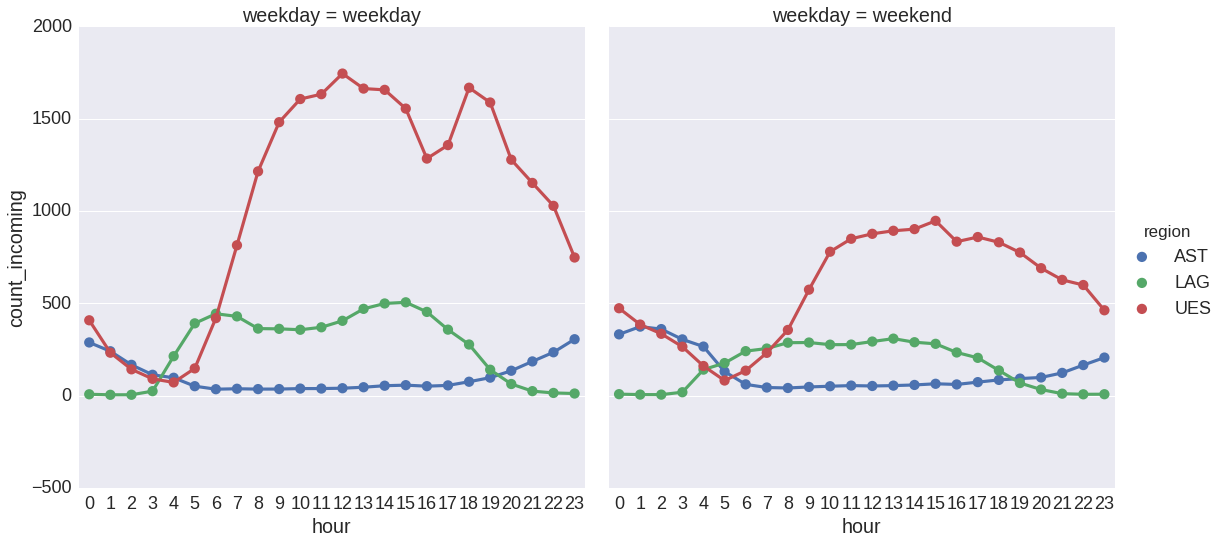

In [100]:
sns.set(font_scale=1.8)

g = sns.factorplot(x='hour',y='count_incoming', col="weekday",
               data=agg_flow,
               hue='region', size=8)
print("number of rides coming in at different hours of the day")

number of rides going out at different hours of the day


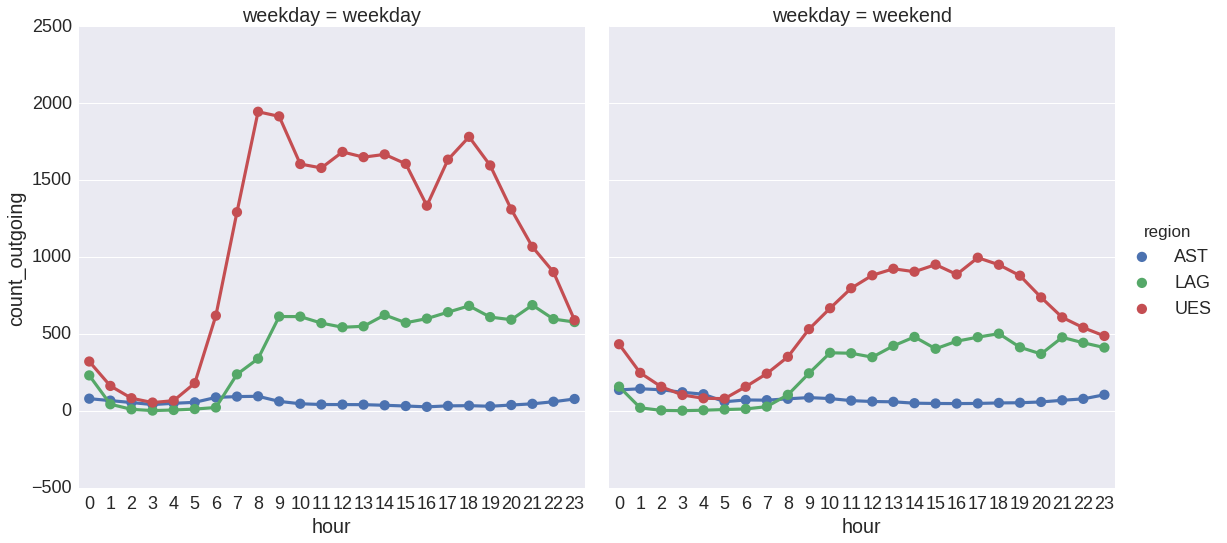

In [101]:
g = sns.factorplot(x='hour', y='count_outgoing', col="weekday",
               data=agg_flow,
               hue='region', size=8)
plt.yticks(rotation=15)
print("number of rides going out at different hours of the day")

(# rides coming in - # rides going out) at different hour of the day


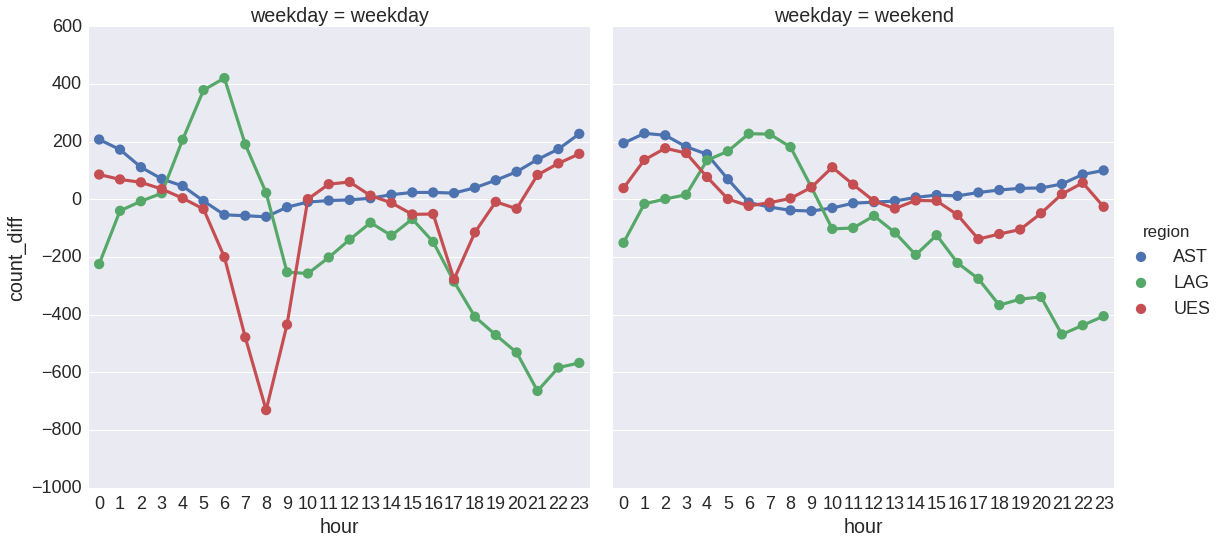

In [102]:
sns.factorplot(x='hour',y='count_diff', col="weekday",
               data=agg_flow,
               hue='region', size=8)
plt.yticks(rotation=15)
print("(# rides coming in - # rides going out) at different hour of the day")

### the potential of improving efficiency by recommending next pickup for drivers

In [49]:
AVG_SPEED = 0.2

def get_time(row):
    travel_time = row.next_pickup_dist/AVG_SPEED
    if travel_time > row.opt_wait_time:
        return travel_time
    else:
        return row.opt_wait_time

def get_recommend_table(zone_name):
    
    df_recommend = pd.read_csv("./recommendation/{0}/{0}_recommend_next_rides_total.csv" \
                               .format(zone_name))

    del df_recommend["Unnamed: 0"]
    del df_recommend["Unnamed: 0.1"] 
    del df_recommend["Unnamed: 0.1.1"]

    df_recommend["rec_wait_time"] = df_recommend.apply(lambda x: get_time(x), axis=1)
    df_recommend["region"] = zone_name
    return df_recommend

In [52]:
astoria_recommend = get_recommend_table("AST")
laguardia_recommend = get_recommend_table("LAG")
upper_east_recommend = get_recommend_table("UES")

In [53]:
df_rec_wait = pd.concat([astoria_recommend, laguardia_recommend, upper_east_recommend], axis = 0)
agg_rec_wait = df_rec_wait[["rec_wait_time", "region"]].groupby("region").describe().stack(level=1).reset_index()
agg_rec_wait.columns = ['region', 'statistics', 'wait_time']

In [83]:
agg_wait["status"] = "original"
agg_rec_wait["status"] = "optimized"
compare = pd.concat([agg_wait, agg_rec_wait], axis=0)
if DEBUG:
    compare.head()

comparisons of the median waiting time between the original case and after recommendations


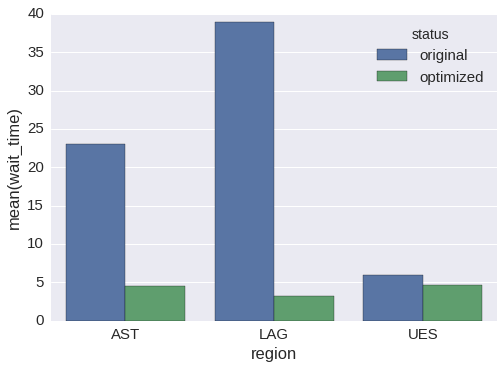

In [104]:
sns.set(font_scale=1.5)
g = sns.barplot(x='region',y='wait_time',
            data=compare[compare.statistics=="50%"], 
            hue='status')
print("comparisons of the median waiting time between the original case and after recommendations")

Statistical questions – answer these theoretically, no need to implement:
1. If you were given a metric for efficiency (assume you don't know how it's calculated), how would you determine whether a specific zone is more efficient than the rest of the city? How would you determine why it’s more efficient?
2. How would you compare the distributions of intra-city trip prices between two different cities? How would you test whether any differences you find are explained by distance and duration?


In [15]:
# query the rides information table for future use
# pickup_datetime, dropoff_datetime, pickup_LocationID, 
#                                dropoff_LocationID, medallion
query_taxi = '''SELECT DISTINCT medallion
                FROM trip_data'''
df_taxi = pd.read_sql_query(query_taxi, disk_engine)
medallions = df_taxi.medallion.tolist()

pickle.dump(medallions,open("medallions_all.txt","w"))

In [5]:
def add_other_zones(zones):
    df_in = query_flow(zones, is_in=True)
    df_in["hour"] = df_in["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
    df_in["region"] = df_in["pickup_LocationID"].apply(region)
    df_flow_in = pd.concat([df_flow_in, df_in], axis=0)
    print "Number of rides in: ", len(df_flow_in)

    agg_flow_in = df_flow_in[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
    agg_flow_in.columns = ["region", "hour", "count_incoming"]
    if DEBUG:
        print agg_flow_in.head()
        
    df_out = query_flow(zones, is_in=False)
    df_out["hour"] = df_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
    df_out["region"] = df_out["pickup_LocationID"].apply(region)
    df_flow_out = pd.concat([df_flow_out, df_out], axis=0)
    if DEBUG:
        print "Number of rides in: ", len(df_flow_out)

    agg_flow_out = df_flow_out[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
    agg_flow_out.columns = ["region", "hour", "count_outgoing"]
    if DEBUG:
        print agg_flow_in.head()

In [ ]:
#add_other_zones(Jackson_zones)

#add_other_zones(Woodside_zones)